# This is a quick demo of `ramantools`. Documentation can be found [here](https://zrbyte.github.io/ramantools/).

In [1]:
import ramantools as rt
import matplotlib.pyplot as pl

Loading test data from a URL

In [23]:
# For use only in this tutorial.
import urllib

# link to datafile
datalink = 'https://public.ek-cer.hu/~nemes/testdata/FLG36.MK_FLG_ABC_36--Scan%20Piezo--013--Spec.Data%201.txt'
# link to infofile
infolink = 'https://public.ek-cer.hu/~nemes/testdata/FLG36.MK_FLG_ABC_36--Scan%20Piezo--013--Information.txt'

f = urllib.request.urlopen(datalink)
myfile = f.read().decode('latin1').replace('\n', ' ')
with open('data.txt', mode = 'w', encoding = 'latin1') as f:
    f.write(myfile)

f = urllib.request.urlopen(infolink)
myfile = f.read().decode('latin1').replace('\n', ' ')
with open('info.txt', mode = 'w', encoding = 'latin1') as f:
    f.write(myfile)

In [2]:
map_path = 'data.txt'
info_path = 'info.txt'

In [3]:
# Load the raman map
map = rt.ramanmap(map_path, info_path)

In [4]:
# remove the downloaded files
import os
os.remove('data.txt')
os.remove('info.txt')

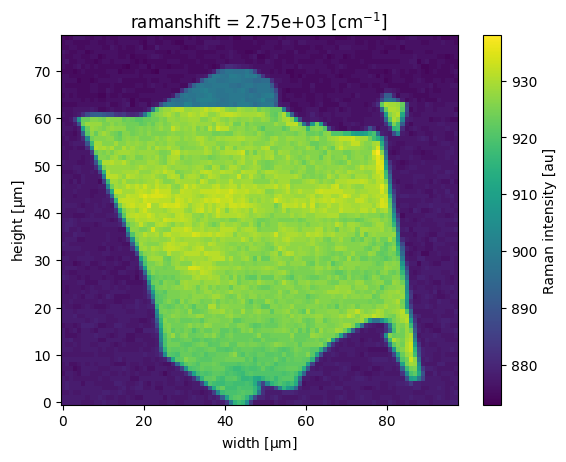

In [4]:
# plot a density plot of the Raman intensity at 2750 cm^-1
map.mapxr.sel(ramanshift = 2750, method = 'nearest').plot()

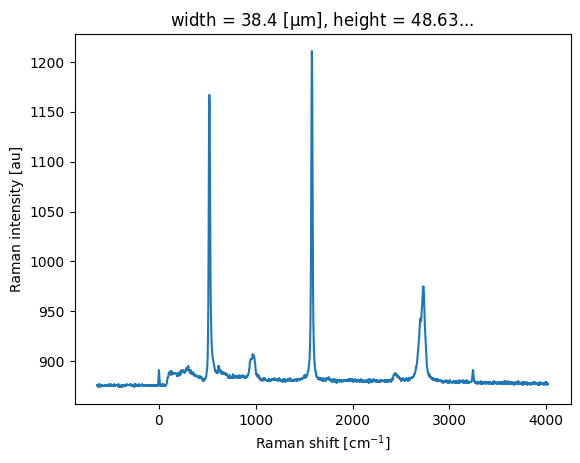

In [26]:
# plot the middle spectrum (using "numpy-like" index based slicing) of the mapxr `xarray` instance
map.mapxr[:, int(map.size_x/2), int(map.size_y/2)].plot()

Let's calibrate the Raman shift to the Si peak at 520.5 1/cm.

In [5]:
map = map.calibrate(520.5)

In [6]:
# remove background
map_nobg, coeff, covar = map.remove_bg()

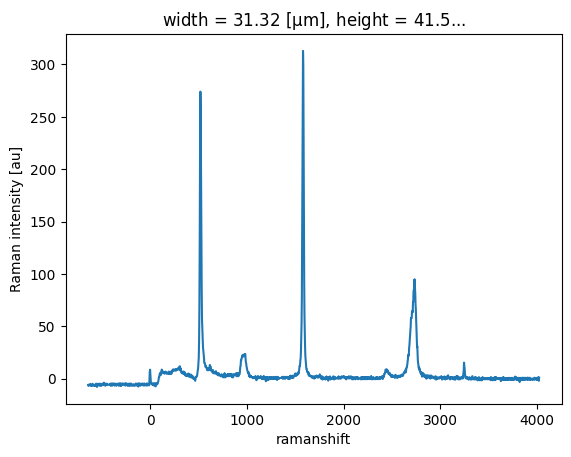

In [7]:
# plot a spectrum from the `ramanmap` instance, with the background removed,
# at the specified coordinates, using the `sel()` method of `xarray`
map_nobg.mapxr.sel(width = 31, height = 42, method = 'nearest').plot()

Let's normalize the spectra to the G peak amplitude.

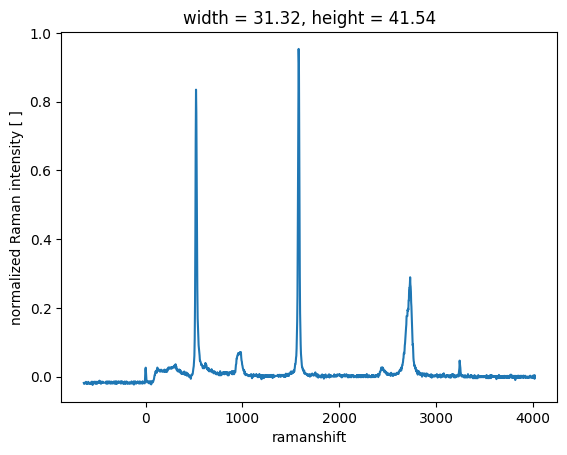

In [11]:
# normalize each spectrum to the G peak amplitude
map_norm = map_nobg.normalize(1582, mode = 'individual')

# plot one of the spectra
map_norm.mapxr.sel(width = 31, height = 42, method = 'nearest').plot()

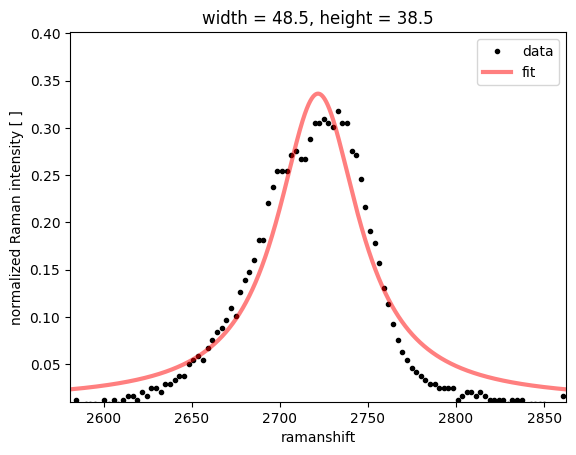

In [12]:
# fit a Lorenzian to the peak at ~2750
fit = rt.peakfit(map_norm.mapxr, toplot = True, stval = {'x0': 2750, 'ampl': 0.5, 'width': 50, 'offset': 0})

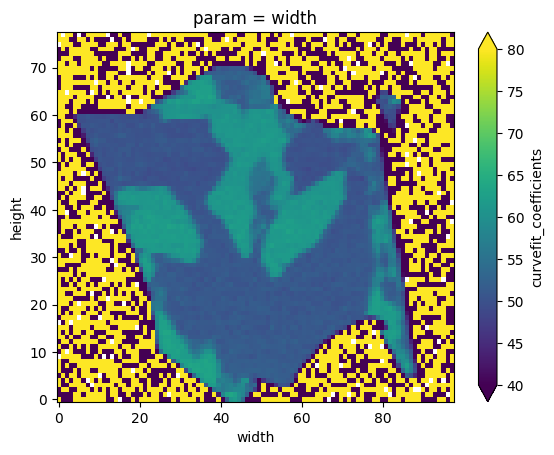

In [13]:
# plot the width of the peak on a density plot
fit['curvefit_coefficients'].sel(param = 'width').plot(vmin = 40, vmax = 80)

Let's create a boolean mask based on the intensity of the G peak. After which we will use this for more efficient fitting and to plot the flake area and the area of the regions with a wide 2D peak.

In [14]:
gpeak = map.mapxr.sel(ramanshift = slice(1550, 1610))

In [15]:
# Taking the mean value of the G peak in the above range (1550 to 1610).
# This is similar to the "sum" filter in the Witec software
gmean = gpeak.mean(dim = 'ramanshift')

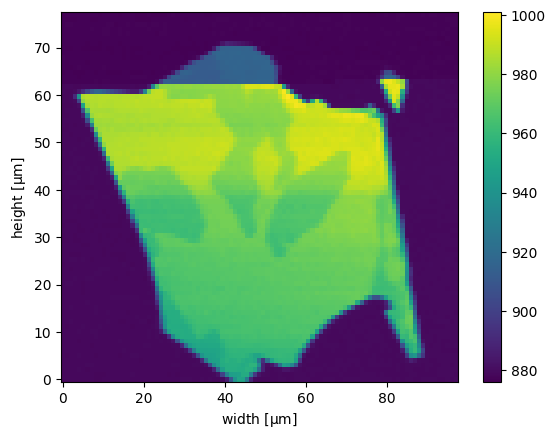

In [16]:
# Let's plot this
gmean.plot()

In [17]:
# Let's now make a boolean mask `gmask` in the areas where the mean of the G peak intenity is larger than 900
gmask = gmean > 900

In [18]:
# This dropps all data, where the G peak is not there.
flake_only = map_nobg.mapxr.where(gmask)

Let's calculate the area of the flake, by using this mask. We just need to count the number of `True` values in the mask.

In [19]:
# this is the area of a pixel
pixel_area = (map_nobg.size_x / map_nobg.pixel_x) * (map_nobg.size_y / map_nobg.pixel_y)
# to get the flake area we just need to sum the mask. This works because: True + True = 2 :)
flake_area = gmask.sum() * pixel_area
print('flake area is:', flake_area.data, 'um^2')

flake area is: 3742.0 um^2


In [20]:
# Let's make another fit. This time fitting only to the flake
p = {'x0': 2724, 'ampl': 313, 'width': 49, 'offset': 0}
mapfit_gmask = rt.peakfit(flake_only, stval = p)

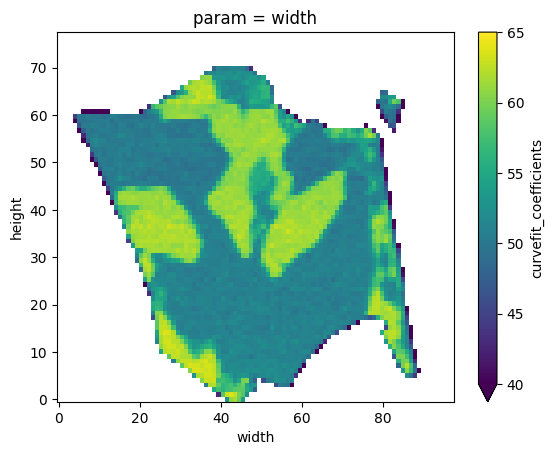

In [21]:
# Let's plot the 2D peak width
twodpeak_width = mapfit_gmask['curvefit_coefficients'].sel(param = 'width')
twodpeak_width.plot(vmin = 40, vmax = 65)

In [22]:
# make another mask, based on the peak width
wide_twod_mask = twodpeak_width > 55
wide_twod = twodpeak_width.where(wide_twod_mask)

Let's highlight with red, the areas with a peak width > 55

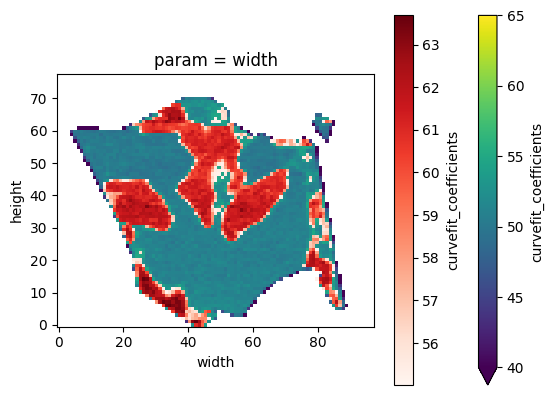

In [23]:
twodpeak_width.plot(cmap = 'viridis', vmin = 40, vmax = 65)
wide_twod.plot(cmap = 'Reds', alpha = 1)
ax = pl.gca()
ax.set_aspect(1)

Let's now calculate the percentage of the flake that is covered by areas, where the peak is wider than 55 cm$^{-1}$

In [24]:
wide_twod_area = wide_twod_mask.sum() * pixel_area
print('the area with a peak width > 55 is:', wide_twod_area.data, 'um^2')
print('This is ', str(100*wide_twod_area.data / flake_area.data)[:4], '% of the total flake area.')

the area with a peak width > 55 is: 1342.0 um^2
This is  35.8 % of the total flake area.


Let's plot a histogram of the 2D peak width values only in the area where it is larger than 55 cm^-1

Text(0.5, 0, 'peak width (cm$^{-1}$)')

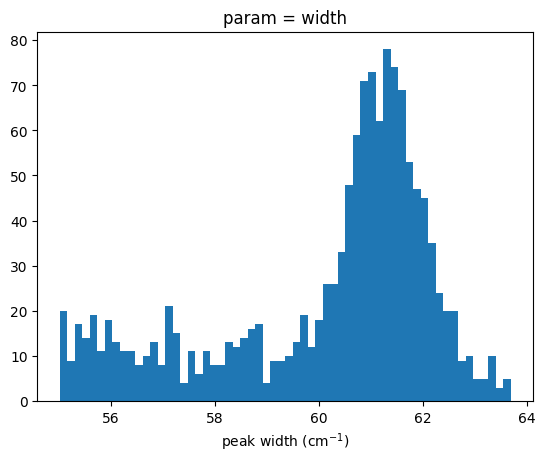

In [25]:
flake_flatten = wide_twod.stack(pos = ['width', 'height'])
# drop the NaN values
flake_flatten = flake_flatten.dropna(dim = 'pos')
_ = flake_flatten.plot.hist(bins = 60)
pl.xlabel('peak width (cm$^{-1}$)')